# Qiskit Workshop: Sample-based Quantum Diagonalization (SQD)

#### qiskit_addon_sqd: https://qiskit.github.io/qiskit-addon-sqd/

#### Requirements:

- `qiskit_addon_sqd`
- `pyscf`

#### Premise

Solve the following Fermionic Hamiltonian for a given molecule and find the ground state energy:

\begin{split}\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+
\sum_{ \substack{prqs\\\sigma\tau} }
\frac{(pr|qs)}{2} \,
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma}\end{split}


#### Method: SQD

<img src='https://qiskit.github.io/qiskit-addon-sqd/_images/sqd_diagram.png' width=75%>




In [1]:
import warnings

warnings.filterwarnings("ignore")

import utils

import numpy as np

## Step -1: Initiate Qiskit Runtime

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name='pinq2_onprem_internal')
backend = service.backend('ibm_quebec')

## Step 0: Pre-processing to define the problem

Molecule of interest: nitrogen ($\text{N}_2$)

Use PySCF library to classically compute some needed quantities.

In [3]:
import pyscf
import pyscf.cc
import pyscf.mcscf

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

converged SCF energy = -108.835236570774


In [4]:
# Compute exact energy
exact_energy = cas.run().e_tot

CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


Get initial estimate of t1 and t2 amplitudes from classical coupled cluster methods (CCSD)

In [6]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988306


## Step 1: Map problem to a quantum circuit

Use the Local Unitary Cluster Jastrow (LUCJ) ansatz from the `ffsim` library.

<img src='https://pubs.rsc.org/image/article/2023/sc/d3sc02516k/d3sc02516k-f2.gif'>

In [7]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 2
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

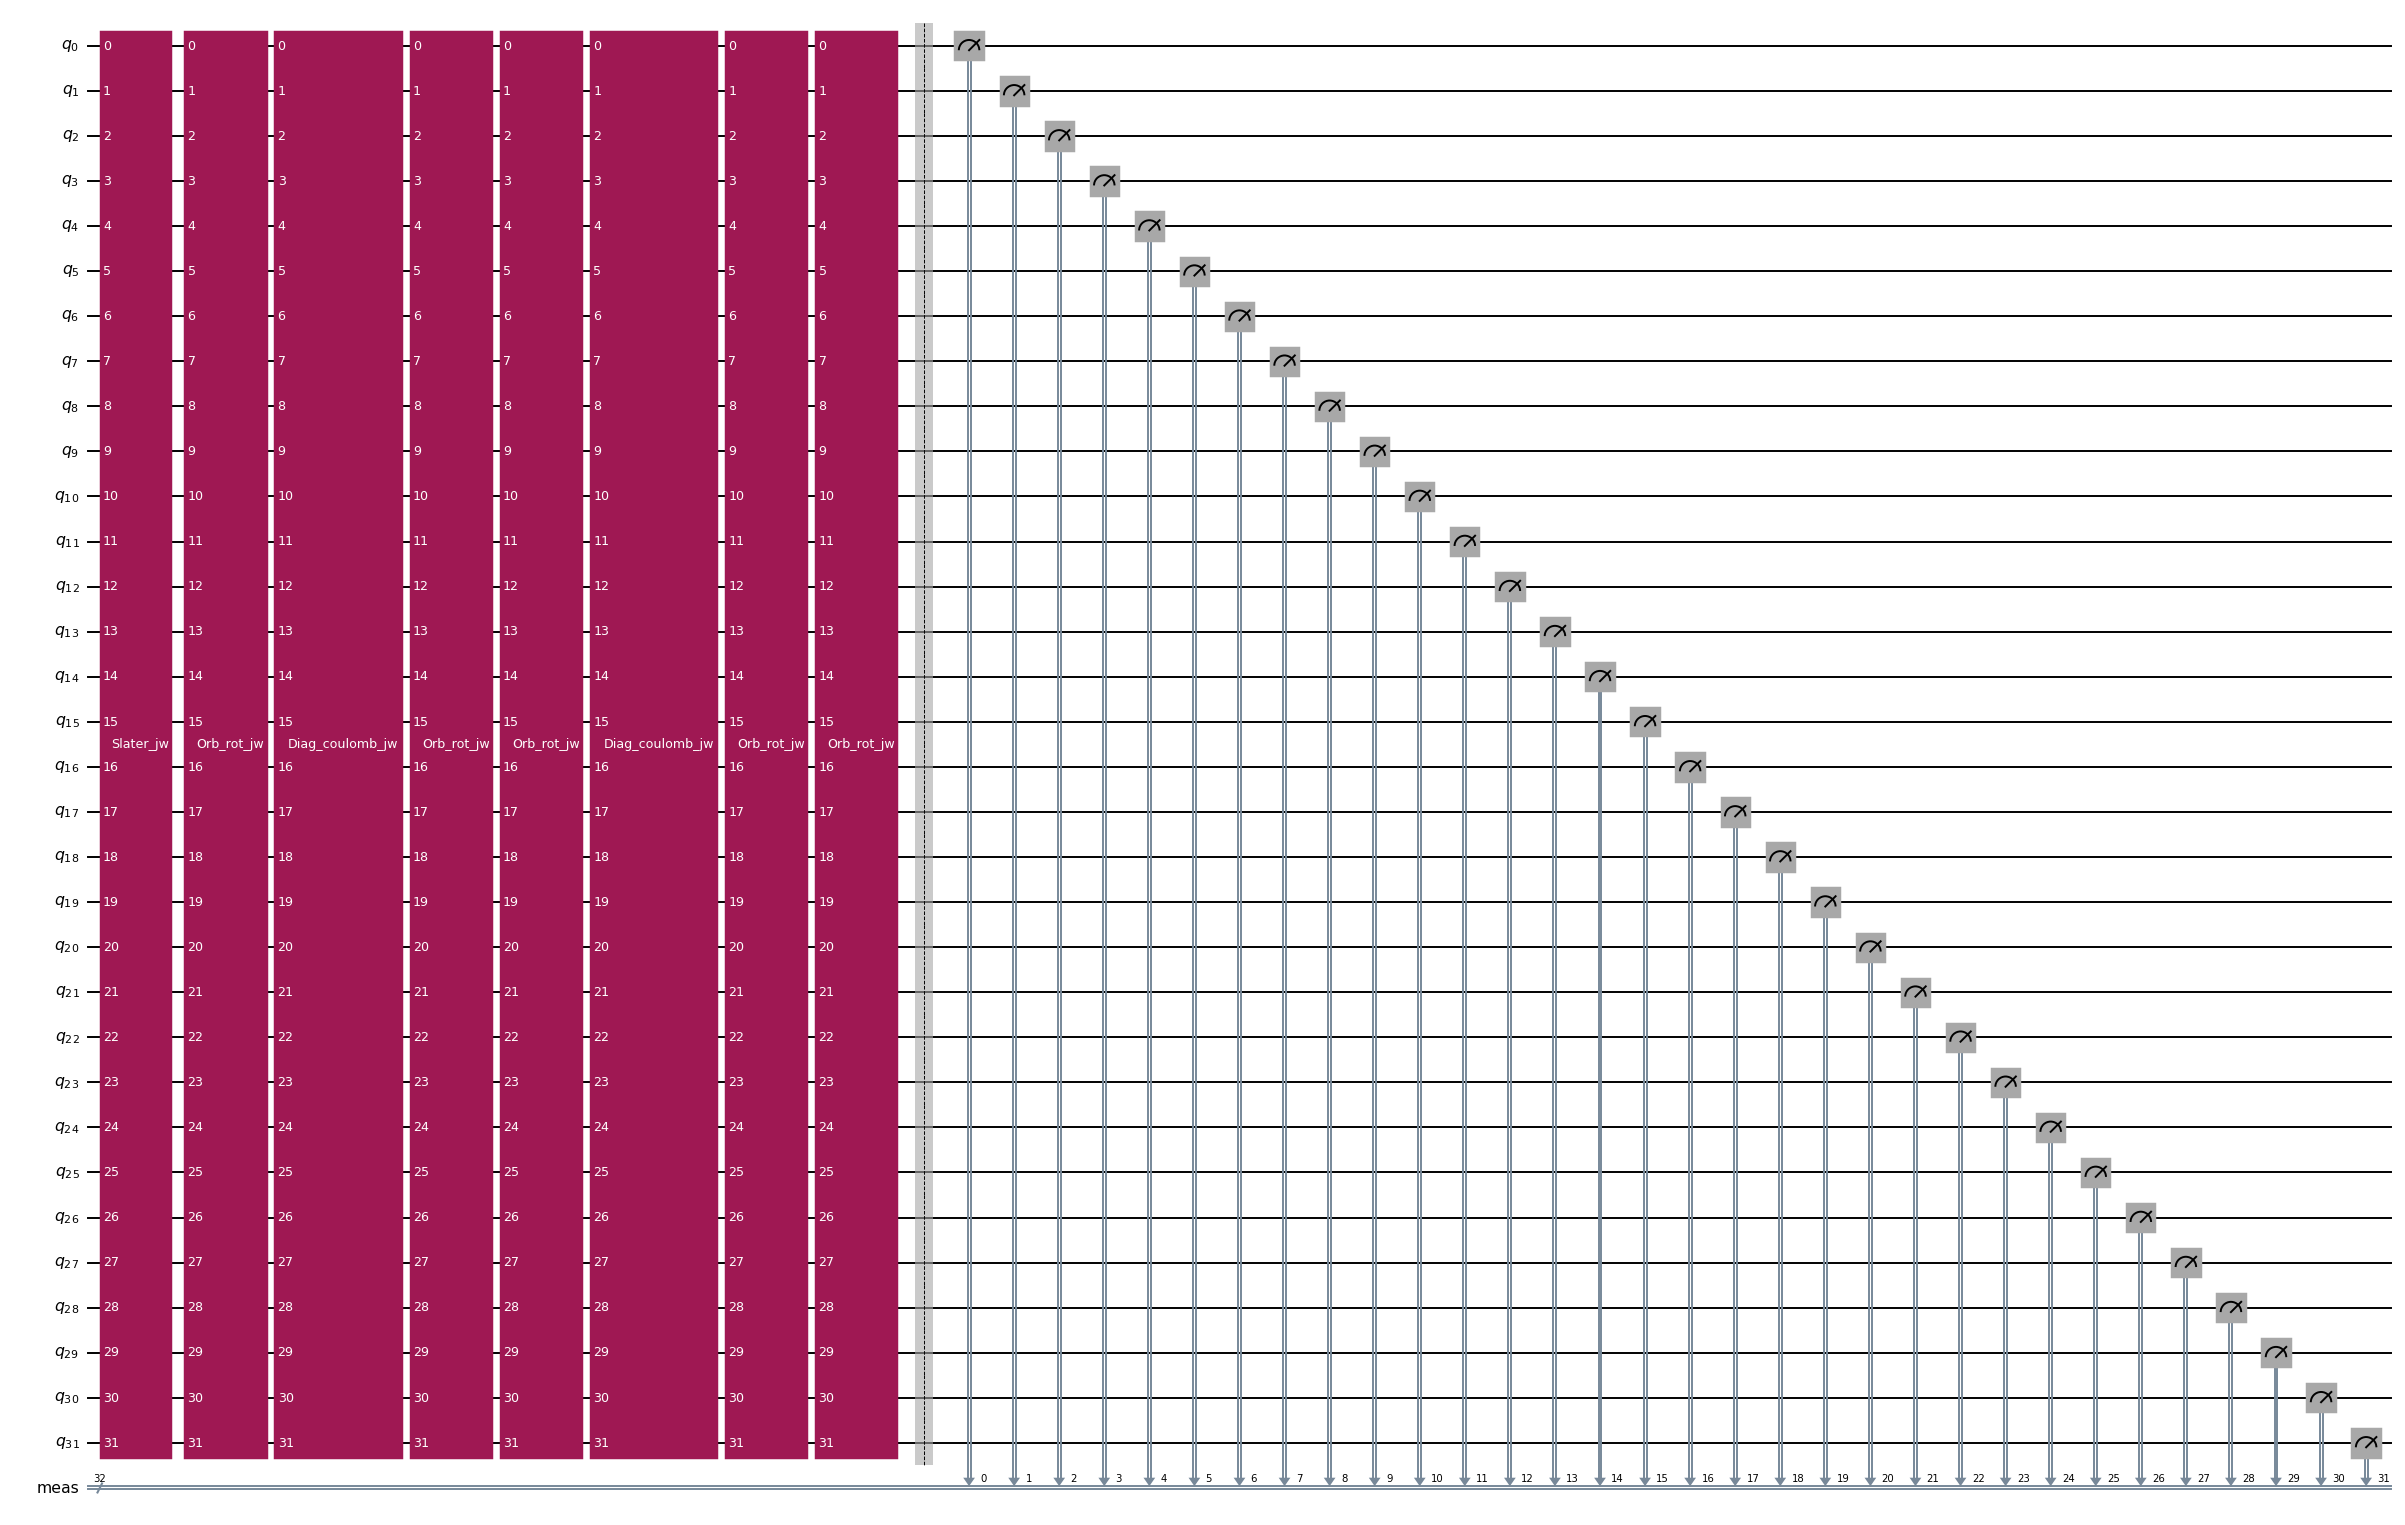

In [8]:
circuit.decompose().draw(scale=0.7, fold=False)

## Step 2: Optimize the circuit

Map circuit to layout of QPU to get best results.

<img src=https://qiskit.github.io/qiskit-addon-sqd/_images/lucj_ansatz_zig_zag_pattern.jpg>

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager

#initial_layout = None

# Layout for Eagle device
#spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
#spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]

# Layout for Heron R2 device
spin_a_layout = [13, 12, 11, 18, 31, 30, 29, 38, 49, 48, 47, 57, 67, 66, 65, 77]
spin_b_layout = [15, 19, 35, 34, 33, 39, 53, 52, 51, 58, 71, 70, 69, 78, 89, 88]

initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, 
    backend=backend, 
    initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes):  {isa_circuit.count_ops()}")
print(f'2-qubit depth (w/o pre-init pases): {utils.get_2q_gate_depth(isa_circuit)}')

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes):   {isa_circuit.count_ops()}")
print(f'2-qubit depth (w/ pre-init pases):  {utils.get_2q_gate_depth(isa_circuit)}')

Gate counts (w/o pre-init passes):  OrderedDict({'sx': 6340, 'rz': 6127, 'cz': 2316, 'x': 268, 'measure': 32, 'barrier': 1})
2-qubit depth (w/o pre-init pases): 184
Gate counts (w/ pre-init passes):   OrderedDict({'sx': 3248, 'rz': 3146, 'cz': 1262, 'x': 165, 'measure': 32, 'barrier': 1})
2-qubit depth (w/ pre-init pases):  119


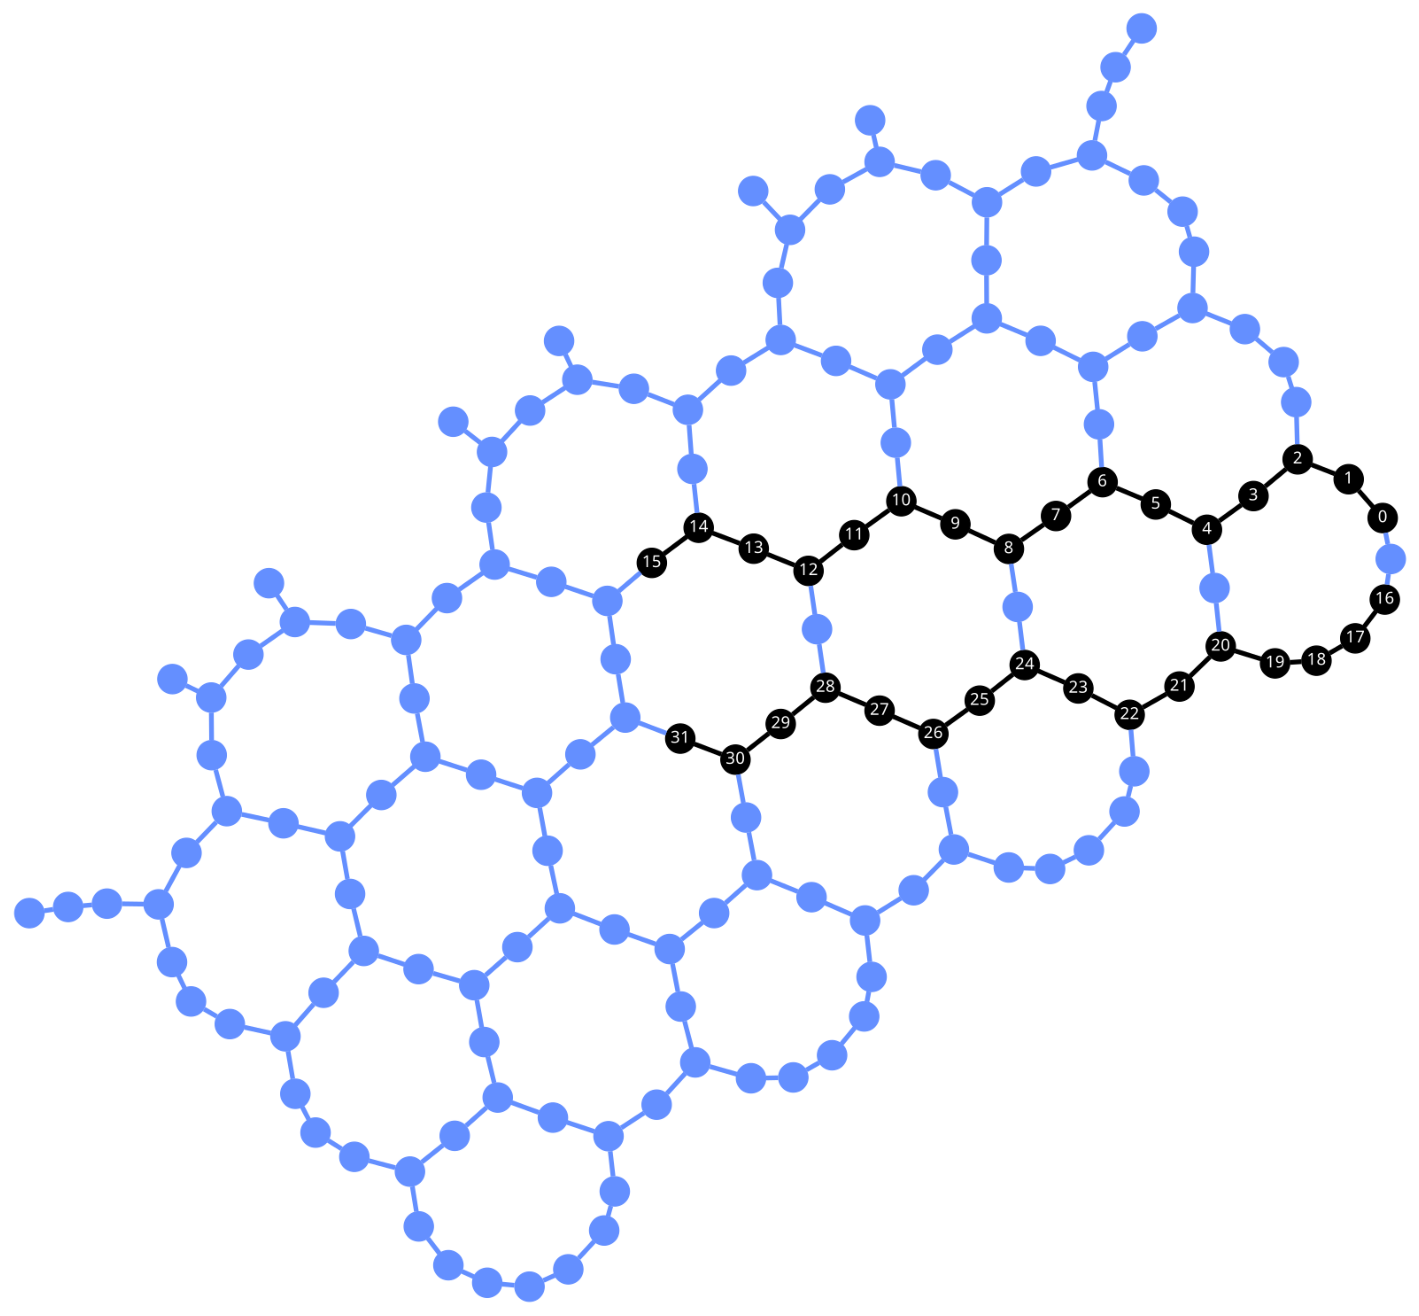

In [15]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

## Step 3: Run circuit

In [16]:
import numpy as np
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=10000)
print(job.job_id())

d41romch4j8s73egt300


In [18]:
job.status()

'DONE'

In [19]:
job = service.job('d41romch4j8s73egt300')

In [31]:
# Get the bitstrings sampled
primitive_result = job.result()
pub_result = primitive_result[0]
bit_array = pub_result.data.meas
counts = bit_array.get_counts()
counts

{'00100000000111100110010000100110': 1,
 '00001000100000101000111110110010': 1,
 '00101000000011110000100000111100': 1,
 '10001000010010000000100110110101': 1,
 '00011100011100000001100101100101': 1,
 '10110010100110010000110111001111': 1,
 '01000110000010100000110000110100': 1,
 '11001000011010100000100111000010': 1,
 '10100100001010011100100101010101': 1,
 '01001110011111001100110010001010': 1,
 '10001000001100011100001001111100': 1,
 '00010000001100010110000001000110': 1,
 '00000000000111110000100101001111': 1,
 '00000000000111110000000001001010': 1,
 '01000100011000101001010010100011': 1,
 '00010010001000101100110111110110': 1,
 '10001000010100100001010010101001': 1,
 '00110000011101110100010101001011': 1,
 '10101110000000001100010000010011': 1,
 '10001000011000010001110100010010': 1,
 '10101010001000111011001001000100': 1,
 '00010001110001010001001100000100': 1,
 '10000011100010011000001111110011': 1,
 '11101001011011110001100100010101': 1,
 '11100101000011101100101100100000': 1,


In [32]:
# Save the results to a file

import pickle

with open('n2_bit_array.d41romch4j8s73egt300.pkl', 'wb') as file:
    pickle.dump(counts, file)

In [33]:
# Load the results that were saved to the file

with open('n2_bit_array.d41romch4j8s73egt300.pkl', 'rb') as file:
    counts = pickle.load(file)

## Step 4: Postprocess results

Use the SQD classical postprocessing methods to compute final ground state energy. The process includes:

- Configuration recovery
- Project/Diagonalize batches of samples in smaller subspaces
- Iterate and converge to lowest energy

In [34]:
rng_seed = 24
rng = np.random.default_rng(rng_seed)

In [ ]:
from functools import partial

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 1
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


# Prints the intermediate results at each iteration of configuration recovery
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -108.97758467019565
		Subspace dimension: 178084
Iteration 2
	Subsample 0
		Energy: -109.01724394751594
		Subspace dimension: 293764
Iteration 3
	Subsample 0
		Energy: -109.02345467483258
		Subspace dimension: 429025
Iteration 4
	Subsample 0
		Energy: -109.03593896345534
		Subspace dimension: 521284
Iteration 5
	Subsample 0
		Energy: -109.0374103699422
		Subspace dimension: 678976


### Plot the results

Exact energy: -109.04667 Ha
SQD energy: -109.03741 Ha
Absolute error: 0.00926 Ha


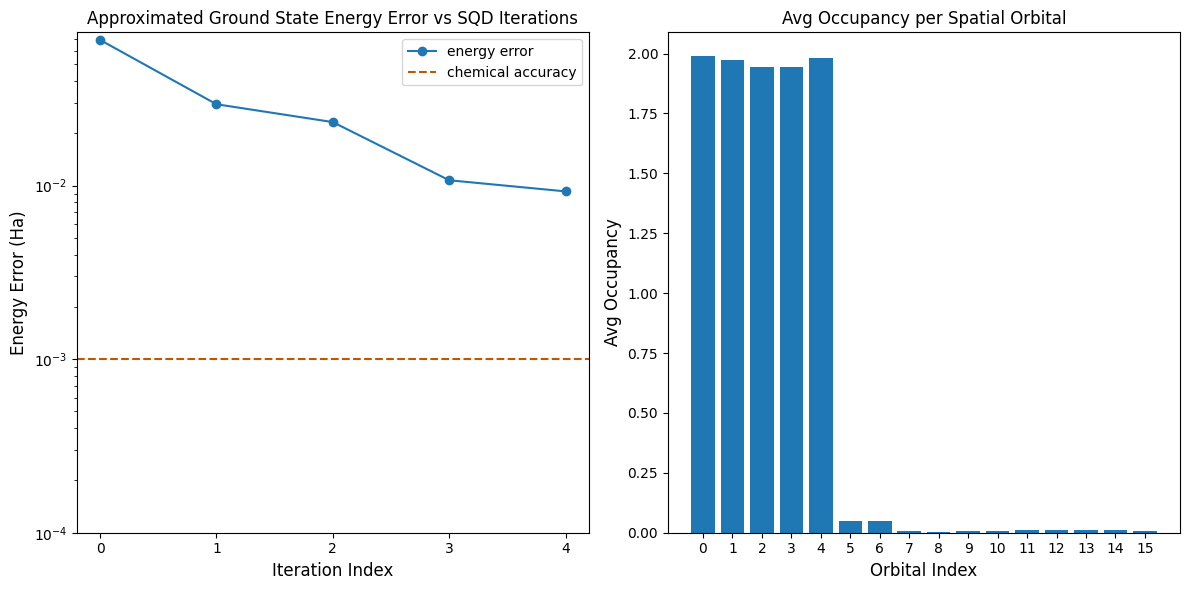

In [36]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f} Ha")
print(f"SQD energy: {min_e[-1]:.5f} Ha")
print(f"Absolute error: {e_diff[-1]:.5f} Ha")
plt.tight_layout()
plt.show()